# GRAPE for time-dependent hamiltonians

## Simulation

In [ ]:
# ruff: noqa
import feedback_grape.grape as fg
from feedback_grape.utils.solver import sesolve
from feedback_grape.grape import plot_control_amplitudes, fidelity
import jax.numpy as jnp
from feedback_grape.utils.operators import *
from feedback_grape.utils.states import basis, coherent
from feedback_grape.utils.tensor import tensor

T = 1  # microsecond
num_of_intervals = 100
N = 30  # dimension of hilbert space
alpha = 1.5
# Phase for the interference
phi = jnp.pi
hconj = lambda a: jnp.swapaxes(a.conj(), -1, -2)
chi = 0.2385 * (2 * jnp.pi)
mu_qub = 4.0
mu_cav = 8.0
psi0 = tensor(basis(2), basis(N))
cat_target_state = coherent(N, alpha) + jnp.exp(-1j * phi) * coherent(
    N, -alpha
)
psi_target = tensor(basis(2), cat_target_state)


# Using Jaynes-Cummings model for qubit + cavity
def build_grape_format_ham():
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N))
    adag = tensor(identity(2), create(N))
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N))
    sigp = tensor(sigmap(), identity(N))
    one = tensor(identity(2), identity(N))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    H_ctrl = [H_ctrl_qub, H_ctrl_qub_dag, H_ctrl_cav, H_ctrl_cav_dag]

    return H0, H_ctrl

In [ ]:
import time

start_time = time.time()
# Outputs Fidelity of 0.9799029117042408 but in like 30 minutes
H0, H_ctrl = build_grape_format_ham()
res_fg = fg.optimize_pulse(
    H0,
    H_ctrl,
    psi0,
    psi_target,
    num_t_slots=num_of_intervals,
    total_evo_time=T,
    evo_type="state",
    optimizer="l-bfgs",
    propcomp="memory-efficient",
)
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")
print(res_fg.final_fidelity)
print(res_fg.iterations)

In [ ]:
import time

start_time = time.time()
# Outputs Fidelity of 0.9799029117042408 but in like 30 minutes
H0, H_ctrl = build_grape_format_ham()
res_fg = fg.optimize_pulse(
    H0,
    H_ctrl,
    psi0,
    psi_target,
    num_t_slots=num_of_intervals,
    total_evo_time=T,
    evo_type="state",
    optimizer="l-bfgs",
    propcomp="time-efficient",
)
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")
print(res_fg.final_fidelity)
print(res_fg.iterations)

In [ ]:
time_start = 0.0
time_end = 1.0
time_intervals_num = 5

In [ ]:
t_grid = jnp.linspace(time_start, time_end, time_intervals_num)

In [ ]:
H_labels = [r'$u_1$', r'$u_2$', r'$u_3$', r'$u_4$', r'$u_5$']

In [ ]:
t_grid.shape

In [ ]:
res_fg.control_amplitudes.shape

In [ ]:
plot_control_amplitudes(t_grid, res_fg.control_amplitudes, labels=H_labels)

In [ ]:
res_fg.control_amplitudes

## Example of user trying to construct his time dependent Hamiltonian from extracted amplitudes and then get the final operator

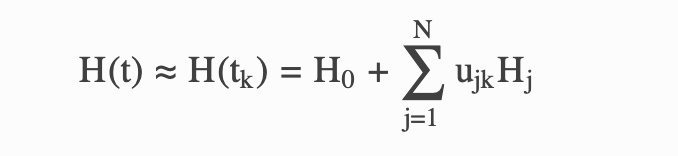

### Define the time grid (same as defined)

In [ ]:
time_start = 0.0
time_end = 1.0
time_intervals_num = 5
N_cav = 10
# Eqivalant to delta_ts = jnp.repeat(0.2, time_intervals_num).astype(jnp.float32)
# However, it is implemented in this way to be more general and
# show that these are the differences between the time intervals
t_grid = jnp.linspace(time_start, time_end, time_intervals_num + 1)
delta_ts = t_grid[1:] - t_grid[:-1]

### Build the Hamiltonian

In [ ]:
def build_ham_reconstructed(u1, u2, u3, u4):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    # Apply control amplitudes
    H_ctrl = (
        u1 * H_ctrl_qub
        + u2 * H_ctrl_qub_dag
        + u3 * H_ctrl_cav
        + u4 * H_ctrl_cav_dag
    )

    H = H0 + H_ctrl
    return H

In [ ]:
u1 = res_fg.control_amplitudes[:, 0]
u2 = res_fg.control_amplitudes[:, 1]
u3 = res_fg.control_amplitudes[:, 2]
u4 = res_fg.control_amplitudes[:, 3]

In [ ]:
u1

### Construct the Hamiltonian for each time step

In [ ]:
H_total = jnp.array(
    [
        build_ham_reconstructed(u1[i], u2[i], u3[i], u4[i])
        for i in range(len(u1))
    ]
)

In [ ]:
H_total

In [ ]:
H_total.shape

### Solve the Schrödinger Equation

In [ ]:
psi0_fg = tensor(basis(2), basis(N_cav))
psi_fg = sesolve(H_total, psi0_fg, delta_ts)

### Calculate fidelity with target

In [ ]:
print(fidelity(C_target=psi_target, U_final=psi_fg, evo_type="state"))